Data Cleaning Pipeline

In [1]:
import rsf_data_collector as rsf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

In [2]:
spring_break_end = pd.Timestamp('2025-03-31')
end_of_semester = pd.Timestamp('2025-05-04')

def get_df():
    sheet = rsf.setup_google_sheets()
    values = sheet.get_all_values()
    headers = values[0]
    rsf_df = pd.DataFrame(values[1:], columns=headers)
    return rsf_df

def filter_gym_data():
    #Only keep data points recorded after spring break (>= 31st)
    df = get_df()
    date_format = '%m/%d/%Y %I:%M:%p'
    #Convert columns to consistent datatypes
    df['pst_timestamp'] = pd.to_datetime(df['pst_timestamp'], format=date_format)
    df['percentage_capacity'] = df['percentage_capacity'].astype(float)
    df = df[(df['pst_timestamp'] >= spring_break_end) & (df['pst_timestamp'] <= end_of_semester)]
    #Only keep data points recorded within hours of operation (due to issues with github workflow)
    df = df[(df['pst_timestamp'].dt.hour >= 7) & (df['pst_timestamp'].dt.hour < 23)]
    #Remove data points where the gym is 0% full
    df = df[df['percentage_capacity'] > 0]
    #Drop UTC timestamp
    df = df.drop(columns=['timestamp'])
    return df

data = filter_gym_data()

In [3]:
#Each row represents a reading from the RSF crowd meter sensor starting from March 31st 2025
data

,percentage_capacity,pst_timestamp
374,48.00,2025-03-31 08:19:00
375,56.00,2025-03-31 08:37:00
376,54.67,2025-03-31 08:47:00
377,56.67,2025-03-31 09:22:00
378,53.33,2025-03-31 09:52:00
...,...,...
1410,57.33,2025-05-03 14:34:00
1411,71.33,2025-05-03 15:10:00
1412,76.00,2025-05-03 15:38:00
1413,83.33,2025-05-03 16:11:00


Scope
- On average, what day of the week is the rsf most busy? least busy?
- Each day, at what hour is the rsf least busy?


In [4]:
# Average occupancy by hour
data['hour'] = [f'{tstamp.hour} AM' if tstamp.hour < 12 else f'{tstamp.hour - 12} PM' for tstamp in data['pst_timestamp']]
avg_by_hour = data.groupby('hour')['percentage_capacity'].mean().sort_values()

# Average occupancy by day of week
data['weekday'] = data['pst_timestamp'].dt.day_name()
avg_by_weekday = data.groupby('weekday')['percentage_capacity'].mean().sort_values()

In [5]:
print(avg_by_weekday, avg_by_hour)

weekday
Sunday       48.228108
Saturday     53.115673
Friday       61.570909
Thursday     65.164416
Wednesday    68.100392
Monday       71.526316
Tuesday      74.254079
Name: percentage_capacity, dtype: float64 hour
7 AM     40.541042
8 AM     46.841750
10 PM    51.389831
9 AM     54.822329
10 AM    60.308625
1 PM     62.820641
2 PM     64.582278
0 PM     66.008000
8 PM     68.777222
11 AM    69.250278
7 PM     73.126897
3 PM     74.396582
9 PM     78.309821
6 PM     79.122632
5 PM     81.443333
4 PM     82.786154
Name: percentage_capacity, dtype: float64


In [21]:
heatmap_pivot = data.pivot_table(index='weekday', columns='hour', values='percentage_capacity', aggfunc='mean')
heatmap_pivot.loc['Saturday']

hour
0 PM     58.726364
1 PM     60.424545
10 AM    51.091818
10 PM     0.670000
11 AM    61.636364
2 PM     58.727273
3 PM     67.394545
4 PM     81.134000
5 PM           NaN
6 PM      0.670000
7 AM           NaN
7 PM           NaN
8 AM     24.726364
8 PM      0.670000
9 AM     45.333636
9 PM      0.670000
Name: Saturday, dtype: float64

Text(0.5, 1.0, 'Average Gym Occupancy by Day and Hour')

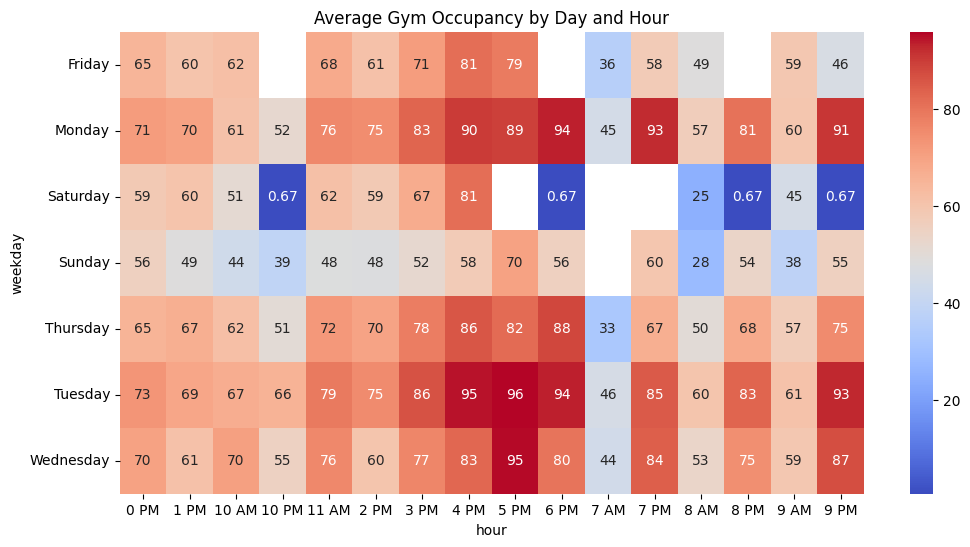

In [8]:
# Visualization example
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_pivot,
    cmap='coolwarm', annot=True
)
plt.title('Average Gym Occupancy by Day and Hour')